In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_all_batches
import matplotlib.pyplot as plt
from itertools import product


# Die Klasse macht aus Numpy-Daten (X_train_seq, y_train) ein PyTorch kompatibles Dataset
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
            return len(self.X)

    def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

In [34]:
# Unser Attention-Mechanismus

class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Sequential(                       # Ein kleines nn, das einen Score für diesen Zeitschritt angibt (Wie wichtig?)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_outputs):
        # lstm_outputs: (batch, seq_len, hidden)
        attn_scores = self.attn(lstm_outputs)              # Jeden Zeitschritt eine Zahl, wie wichtig es ist
        attn_weights = torch.softmax(attn_scores, dim=1)   # In Prozente umwandeln, die sich zu 1 addieren
        context = torch.sum(attn_weights * lstm_outputs, dim=1)  # (batch, hidden)
        return context, attn_weights.squeeze(-1)

In [35]:
# LSTM-Modell Klasse

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lr, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout
        )
        
        self.attention = AttentionMechanism(hidden_size)

        # Hier wird der Output des Modells zusammen mit Attention ausgeegeben
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    
    def forward(self, x):
        device = x.device
        
        # Hidden- und Cellstate sind zu Beginn leer und werden während des Trainings immer aktualisiert
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)

        # gibt gesamte Sequenz und letzten state zurück
        out, (hn, cn) = self.lstm(x, (h0, c0))       # out: (batch, seq_len, hidden)
        context, attn_weights = self.attention(out)  # (batch, hidden)

        # hn[-1] = letzter hidden state der letzten LSTM-Schicht 
        lstm_output = hn[-1]  # (batch, hidden)

        # Das ist der Bypass-Mechanismus
        combined = torch.cat((lstm_output, context), dim=1)  # (batch, hidden*2)

        out = self.fc(combined)
        return out, attn_weights   # 1. Output ist Classification, 2. Output ist Attention-Kontext


    # Berechnet Loss und aktualisiert Gradienten
    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs, _ = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()


    # Wie train_step, aber für Testdaten
    def test_step(self, batch):
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs, _ = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        return loss.item()
        

    # Plottet das Verhalten (mean) von Trainloss und Testloss grafisch
    def plot_loss(self, train_losses, test_losses):
        epochs = len(train_losses)
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), train_losses, marker='o', label="Train Loss")
        plt.plot(range(1, epochs+1), test_losses, marker='o', color='red', label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.title("Training vs Test Loss")
        plt.legend()
        plt.grid(True)
        plt.show()


    # Berechnet losses von Training/Test pro Epoche, mittelt sie, gibt sie schrittweise aus
    def train_model(self, train_loader, test_loader, epochs):
        all_train_losses = []
        all_test_losses = []
        
        for epoch in range(epochs):
            # Training 
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_train_loss = total_loss / len(train_loader)
            all_train_losses.append(avg_train_loss)
        
            # Testen
            total_test_loss = 0
            with torch.no_grad():  # (keine Gradienten beim Testen)
                for batch in test_loader:
                    loss = self.test_step(batch)  
                    total_test_loss += loss
            avg_test_loss = total_test_loss / len(test_loader)
            all_test_losses.append(avg_test_loss)
        
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")
        
        self.plot_loss(all_train_losses, all_test_losses)
        
        return all_train_losses, all_test_losses
        

    # Evaluiert ohne Gradienten; berechnet Accuracy
    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs, _ = self(X_batch)    # Underscore, da wir zwei Outputs bekommen, aber nur die Vorhersage wollen
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    
    # Speichere Ergebnis
    def save(self, path):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")


    # Lade Ergebnis
    def load(self, path):
        self.load_state_dict(torch.load(path, map_location=map_location))
        print(f"Model loaded from {path}")

In [36]:
# Hidden-State Driftanalyse
# Kritisches Verhalten <-> h(t-1) - h(t) sprunghaft groß 

def analyze_hidden_drift(model, X_seq, device, threshold=None):
    model.eval()
    with torch.no_grad():
        X_seq = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(0).to(device) # (1, seq_len, features)

        h0 = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)
        c0 = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)

        lstm_out, (hn, cn) = model.lstm(X_seq, (h0, c0)) # (1, seq_len, hidden)
        lstm_out = lstm_out.squeeze(0).cpu().numpy()     # (seq_len, hidden)

        # h(t-1) - h(t)
        diffs = np.linalg.norm(np.diff(lstm_out, axis=0), axis=1)

        # Schwellenwert mit IQR 
        if threshold is None:
            q1 = np.percentile(diffs, 25)
            q3 = np.percentile(diffs, 75)
            iqr = q3 - q1
            threshold = q3 + 1.5 * iqr   
            print(f"Berechneter Threshold: {threshold:.4f}\n")

        # Plotten
        plt.figure(figsize=(10,5))
        plt.plot(diffs, marker='o', label='|h(t) - h(t-1)|')
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Kritischer Wert {threshold:.4f}')
        plt.title("LSTM Hidden-State Drift über Zeit")
        plt.xlabel("Zeitindex (0...SEQ_LEN-1)")
        plt.ylabel("h(t) - h(t-1)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Filtert die Punkte über dem Threshold aus und gibt sie an wenn vorhanden
        critical_points = np.where(diffs > threshold)[0]
        if len(critical_points) > 0:
            print(f"WARNING! Kritisches Verhalten erkannt bei Zeitschritt(en): {critical_points.tolist()}")
        else:
            print("\nKein kritisches Verhalten erkannt.")

        return diffs, critical_points

In [37]:
# Datenvorbereitung

folderpath = r"gas+sensor+array+drift+dataset/Dataset"
df = load_all_batches(folderpath)

# Features & Labels
X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

# Normalisieren mittels MinMax
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Aufteilung in Training/Testdaten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sequenzlänge (je größer, umso schwieriger die Interpretation bei der Visualisierung)
SEQ_LEN = 50

# Funktion zum Erstellen von Sequenzen aus den Daten
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1])  
    return np.array(xs), np.array(ys)

# Sequenzen erstellen
X_train_seq, y_train_seq = create_sequences(X_train, y_train - 1, SEQ_LEN) # Labels 0-basiert
X_test_seq, y_test_seq = create_sequences(X_test, y_test - 1, SEQ_LEN)

# PyTorch Dataset + Loader erstellen
train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cuda
Epoch [1/30] | Train Loss: 1.7188 | Test Loss: 1.3442
Epoch [2/30] | Train Loss: 1.0452 | Test Loss: 1.0989
Epoch [3/30] | Train Loss: 0.7128 | Test Loss: 0.5913
Epoch [4/30] | Train Loss: 0.5054 | Test Loss: 0.4070
Epoch [5/30] | Train Loss: 0.3826 | Test Loss: 0.3553
Epoch [6/30] | Train Loss: 0.3209 | Test Loss: 0.2887
Epoch [7/30] | Train Loss: 0.2866 | Test Loss: 0.2352
Epoch [8/30] | Train Loss: 0.2433 | Test Loss: 0.2665
Epoch [9/30] | Train Loss: 0.2206 | Test Loss: 0.2397
Epoch [10/30] | Train Loss: 0.2014 | Test Loss: 0.2213
Epoch [11/30] | Train Loss: 0.1918 | Test Loss: 0.1980
Epoch [12/30] | Train Loss: 0.1810 | Test Loss: 0.2110
Epoch [13/30] | Train Loss: 0.1694 | Test Loss: 0.1748
Epoch [14/30] | Train Loss: 0.1547 | Test Loss: 0.1607
Epoch [15/30] | Train Loss: 0.1434 | Test Loss: 0.1723
Epoch [16/30] | Train Loss: 0.1538 | Test Loss: 0.1591
Epoch [17/30] | Train Loss: 0.1357 | Test Loss: 0.1739
Epoch [18/30] | Train Loss: 0.1317 | Test Loss: 0.1626


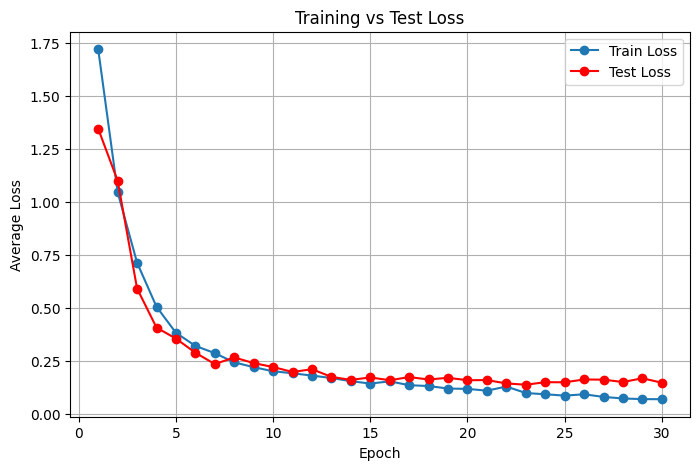

Test Accuracy: 0.9729

 Die ersten N=20 Vorhersagen:

True: Acetaldehyde, Predicted: Acetaldehyde
True: Ethanol, Predicted: Ethanol
True: Acetaldehyde, Predicted: Acetaldehyde
True: Toluene, Predicted: Toluene
True: Acetaldehyde, Predicted: Acetaldehyde
True: Ethanol, Predicted: Ethanol
True: Ammonia, Predicted: Ammonia
True: Ethanol, Predicted: Ethanol
True: Acetaldehyde, Predicted: Acetaldehyde
True: Acetone, Predicted: Acetone
True: Toluene, Predicted: Toluene
True: Acetaldehyde, Predicted: Acetaldehyde
True: Ammonia, Predicted: Ammonia
True: Ammonia, Predicted: Ammonia
True: Acetaldehyde, Predicted: Acetaldehyde
True: Acetone, Predicted: Acetaldehyde
True: Ethanol, Predicted: Ethanol
True: Acetone, Predicted: Acetone
True: Ethanol, Predicted: Ethanol
True: Acetaldehyde, Predicted: Acetaldehyde
Model saved to lstm.pth


In [39]:
# Training starten (Ich empfehle CUDA, auf der CPU wird es mehr Zeit verbrauchen)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(input_size=128, hidden_size=256, num_layers=3, num_classes=6, lr=0.0005, dropout=0.2)
model.to(device)

model.train_model(train_loader, test_loader, epochs=30)
model.evaluate(test_loader)


# Vorhersagen der Gasarten unten
gas_labels = ["Ammonia", "Acetaldehyde", "Acetone", "Ethylene", "Ethanol", "Toluene"]


model.eval()

all_preds = [] # Vorhersagen
all_labels = [] # Echte labels

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs, _ = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

classifications = 20    # Kann größer/kleiner gesetzt werden, je nachdem wie man es will
print(f"\n Die ersten N={classifications} Vorhersagen:\n")

for true_idx, pred_idx in zip (all_labels[:classifications], all_preds[:classifications]):
    print(f"True: {gas_labels[true_idx]}, Predicted: {gas_labels[pred_idx]}")


model.save("lstm.pth")

Berechneter Threshold: 18.0474



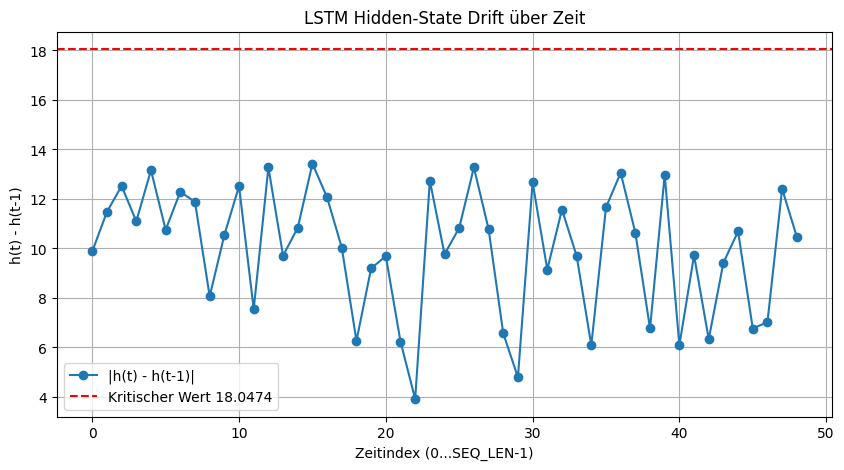


Kein kritisches Verhalten erkannt.


In [40]:
# HiddenState Driftanalyse Visualisierung
sample_seq = X_test_seq[100]
diffs, critical = analyze_hidden_drift(model, sample_seq, device)

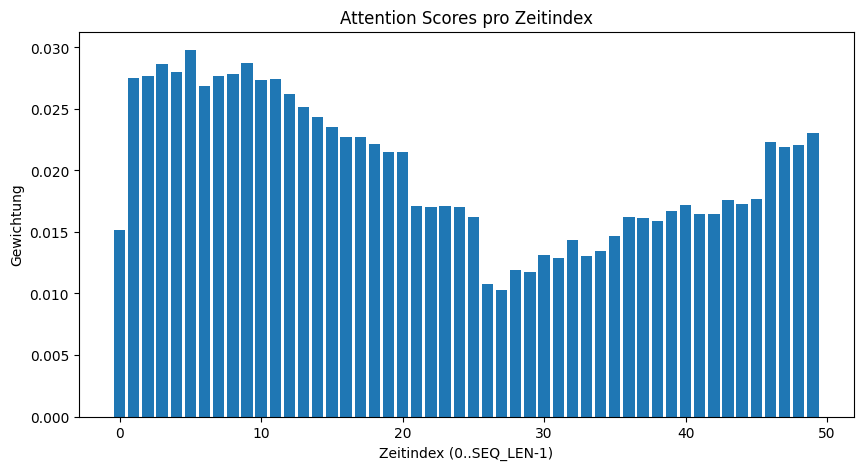

In [41]:
# Attention-Scores Visualisierung
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        _, attn_weights = model(X_batch)
        avg_attn = attn_weights.mean(dim=0).cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.bar(range(len(avg_attn)), avg_attn)
        plt.title("Attention Scores pro Zeitindex")
        plt.xlabel("Zeitindex (0..SEQ_LEN-1)")
        plt.ylabel("Gewichtung")
        plt.show()
        break

Using device: cuda

--- Fold 1/5 ---
Epoch [1/30] | Train Loss: 1.2577 | Test Loss: 0.9859
Epoch [2/30] | Train Loss: 0.9552 | Test Loss: 0.9025
Epoch [3/30] | Train Loss: 0.8144 | Test Loss: 0.7087
Epoch [4/30] | Train Loss: 0.6629 | Test Loss: 0.6376
Epoch [5/30] | Train Loss: 0.5654 | Test Loss: 0.4285
Epoch [6/30] | Train Loss: 0.3410 | Test Loss: 0.1891
Epoch [7/30] | Train Loss: 0.2302 | Test Loss: 0.1212
Epoch [8/30] | Train Loss: 0.1433 | Test Loss: 0.1106
Epoch [9/30] | Train Loss: 0.1452 | Test Loss: 0.1060
Epoch [10/30] | Train Loss: 0.1005 | Test Loss: 0.1173
Epoch [11/30] | Train Loss: 0.1638 | Test Loss: 0.0701
Epoch [12/30] | Train Loss: 0.0789 | Test Loss: 0.0744
Epoch [13/30] | Train Loss: 0.0623 | Test Loss: 0.3027
Epoch [14/30] | Train Loss: 0.0832 | Test Loss: 0.0582
Epoch [15/30] | Train Loss: 0.0473 | Test Loss: 0.0514
Epoch [16/30] | Train Loss: 0.0557 | Test Loss: 0.0434
Epoch [17/30] | Train Loss: 0.0433 | Test Loss: 0.0433
Epoch [18/30] | Train Loss: 0.0396 | 

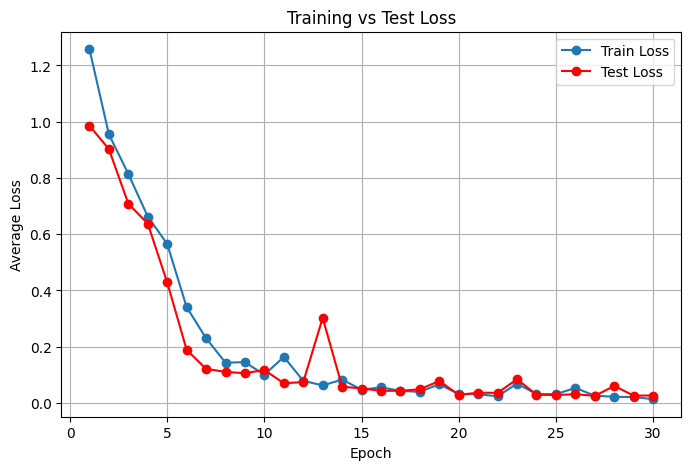

Test Accuracy: 0.9935

--- Fold 2/5 ---
Epoch [1/30] | Train Loss: 1.2876 | Test Loss: 1.0704
Epoch [2/30] | Train Loss: 0.9182 | Test Loss: 0.8557
Epoch [3/30] | Train Loss: 0.7881 | Test Loss: 0.8319
Epoch [4/30] | Train Loss: 0.6205 | Test Loss: 0.4574
Epoch [5/30] | Train Loss: 0.4011 | Test Loss: 0.2937
Epoch [6/30] | Train Loss: 0.2675 | Test Loss: 0.2034
Epoch [7/30] | Train Loss: 0.1799 | Test Loss: 0.1454
Epoch [8/30] | Train Loss: 0.1242 | Test Loss: 0.3109
Epoch [9/30] | Train Loss: 0.1286 | Test Loss: 0.1867
Epoch [10/30] | Train Loss: 0.0834 | Test Loss: 0.1813
Epoch [11/30] | Train Loss: 0.0866 | Test Loss: 0.1122
Epoch [12/30] | Train Loss: 0.0810 | Test Loss: 0.0895
Epoch [13/30] | Train Loss: 0.0649 | Test Loss: 0.0809
Epoch [14/30] | Train Loss: 0.0838 | Test Loss: 0.1236
Epoch [15/30] | Train Loss: 0.0415 | Test Loss: 0.0548
Epoch [16/30] | Train Loss: 0.0589 | Test Loss: 0.0778
Epoch [17/30] | Train Loss: 0.0627 | Test Loss: 0.0649
Epoch [18/30] | Train Loss: 0.0319

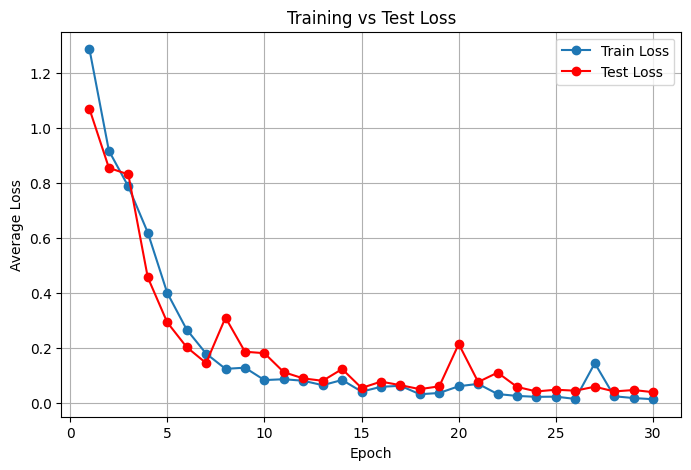

Test Accuracy: 0.9899

--- Fold 3/5 ---
Epoch [1/30] | Train Loss: 1.2859 | Test Loss: 1.0062
Epoch [2/30] | Train Loss: 0.9334 | Test Loss: 0.7987
Epoch [3/30] | Train Loss: 0.7932 | Test Loss: 0.8263
Epoch [4/30] | Train Loss: 0.6352 | Test Loss: 0.8656
Epoch [5/30] | Train Loss: 0.3822 | Test Loss: 0.2341
Epoch [6/30] | Train Loss: 0.2505 | Test Loss: 0.1530
Epoch [7/30] | Train Loss: 0.1674 | Test Loss: 0.1788
Epoch [8/30] | Train Loss: 0.1175 | Test Loss: 0.1041
Epoch [9/30] | Train Loss: 0.0987 | Test Loss: 0.0940
Epoch [10/30] | Train Loss: 0.1552 | Test Loss: 0.1591
Epoch [11/30] | Train Loss: 0.1032 | Test Loss: 0.0751
Epoch [12/30] | Train Loss: 0.0642 | Test Loss: 0.0626
Epoch [13/30] | Train Loss: 0.0473 | Test Loss: 0.0503
Epoch [14/30] | Train Loss: 0.0908 | Test Loss: 0.1244
Epoch [15/30] | Train Loss: 0.0710 | Test Loss: 0.0716
Epoch [16/30] | Train Loss: 0.0757 | Test Loss: 0.0656
Epoch [17/30] | Train Loss: 0.0437 | Test Loss: 0.0472
Epoch [18/30] | Train Loss: 0.0393

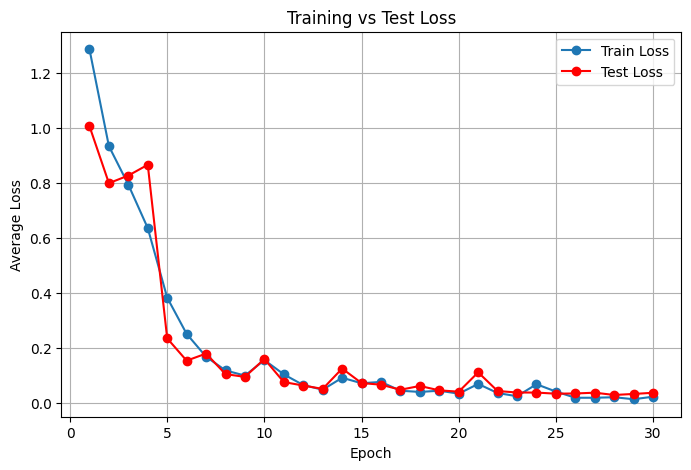

Test Accuracy: 0.9917

--- Fold 4/5 ---
Epoch [1/30] | Train Loss: 1.3131 | Test Loss: 1.5390
Epoch [2/30] | Train Loss: 0.9781 | Test Loss: 0.9084
Epoch [3/30] | Train Loss: 0.7663 | Test Loss: 0.7290
Epoch [4/30] | Train Loss: 0.6484 | Test Loss: 0.5599
Epoch [5/30] | Train Loss: 0.4847 | Test Loss: 0.3523
Epoch [6/30] | Train Loss: 0.3270 | Test Loss: 0.3129
Epoch [7/30] | Train Loss: 0.1801 | Test Loss: 0.1686
Epoch [8/30] | Train Loss: 0.1456 | Test Loss: 0.1752
Epoch [9/30] | Train Loss: 0.1179 | Test Loss: 0.1113
Epoch [10/30] | Train Loss: 0.1415 | Test Loss: 0.2744
Epoch [11/30] | Train Loss: 0.0957 | Test Loss: 0.0954
Epoch [12/30] | Train Loss: 0.0649 | Test Loss: 0.0728
Epoch [13/30] | Train Loss: 0.0987 | Test Loss: 0.0782
Epoch [14/30] | Train Loss: 0.0498 | Test Loss: 0.0738
Epoch [15/30] | Train Loss: 0.0478 | Test Loss: 0.0800
Epoch [16/30] | Train Loss: 0.0594 | Test Loss: 0.0983
Epoch [17/30] | Train Loss: 0.1041 | Test Loss: 0.0579
Epoch [18/30] | Train Loss: 0.1616

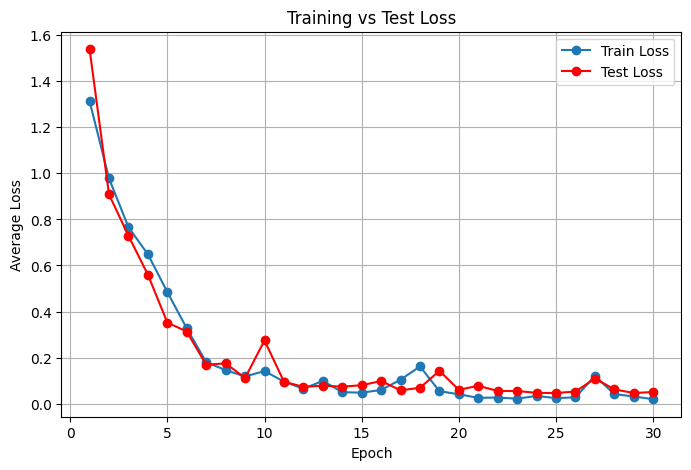

Test Accuracy: 0.9874

--- Fold 5/5 ---
Epoch [1/30] | Train Loss: 1.3081 | Test Loss: 0.9770
Epoch [2/30] | Train Loss: 0.9241 | Test Loss: 0.9391
Epoch [3/30] | Train Loss: 0.8267 | Test Loss: 0.9412
Epoch [4/30] | Train Loss: 0.6371 | Test Loss: 0.4879
Epoch [5/30] | Train Loss: 0.4879 | Test Loss: 0.4183
Epoch [6/30] | Train Loss: 0.3034 | Test Loss: 0.1811
Epoch [7/30] | Train Loss: 0.1670 | Test Loss: 0.1409
Epoch [8/30] | Train Loss: 0.1766 | Test Loss: 0.1802
Epoch [9/30] | Train Loss: 0.1136 | Test Loss: 0.0838
Epoch [10/30] | Train Loss: 0.0884 | Test Loss: 0.1044
Epoch [11/30] | Train Loss: 0.1278 | Test Loss: 0.0965
Epoch [12/30] | Train Loss: 0.0780 | Test Loss: 0.0717
Epoch [13/30] | Train Loss: 0.0816 | Test Loss: 0.1054
Epoch [14/30] | Train Loss: 0.0510 | Test Loss: 0.0543
Epoch [15/30] | Train Loss: 0.0415 | Test Loss: 0.3341
Epoch [16/30] | Train Loss: 0.1778 | Test Loss: 0.0628
Epoch [17/30] | Train Loss: 0.0484 | Test Loss: 0.0526
Epoch [18/30] | Train Loss: 0.0525

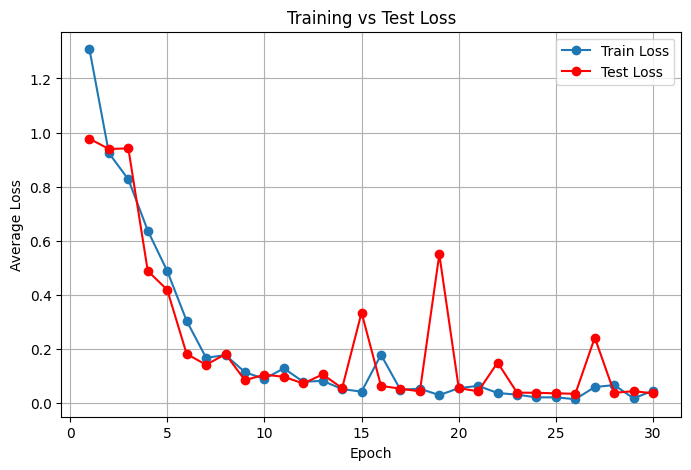

Test Accuracy: 0.9921

Average Validation Accuracy across 5 folds: 0.9909


In [42]:
# 5-Fold Crossvalidation (Bitte Zeit mitnehmen, falls Sie CPU nutzen und diese Zelle ausführen möchten)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Sequenzen einmal erstellen
X_seq, y_seq = create_sequences(X, y - 1, SEQ_LEN)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/5 ---")
    
    # Fold-Daten
    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]
    
    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    model = LSTM(input_size=128, hidden_size=256, num_layers=3, num_classes=6, lr=0.0005, dropout=0.2)
    model.to(device)
    
    model.optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    
    model.train_model(train_loader, val_loader, epochs=30)
    
    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Gibt den mean der folds aus
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Validation Accuracy across 5 folds: {avg_acc:.4f}")

In [11]:
# Standardabweichung als Nachtrag
# Die Einträge aus der unteren Liste entsprechen den Ergebnissen aus dem 5-Fold Cross-Validation aus der oberen Zelle

fold_accuracies = [0.9935, 0.9899, 0.9917, 0.9874, 0.9921] 

std_dev = np.std(fold_accuracies)
print(f"Standard deviation across 5 folds: {std_dev:.4f}")

Standard deviation across 5 folds: 0.0021


In [ ]:
# GRID SEARCH (Bereits durchgeführt - vollstängigkeitshalber aber hier zu sehen) 
# Beste Parameter: hidden_size=256, num_layers=3

# Nach Absprache mussten diese Hyperparameter getestet werden 
param = {
    "hidden_size": [16, 32, 64, 128, 256],
    "num_layers": [1, 2, 3]
}

# Bildet das Kreuzprodukt 
param_combi = list(product(
    param["hidden_size"],
    param["num_layers"]
))

results = []

for hidden_size, num_layers in param_combi:
    print(f"\nTesting params: hidden_size={hidden_size}, num_layers={num_layers}")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, num_classes=6, lr=0.0005)
    model.train_model(train_loader, test_loader, epochs=30)

    acc = model.evaluate(test_loader)
    results.append((hidden_size, num_layers, acc))

# letztlich, wird auf die accuracy aller Elemente geschaut und die beste Kombi ausgegeben
best = max(results, key=lambda x: x[-1])
print("\nBeste Hyperparameter-Kombination:", best)